In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Sampler
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import Dict, List, Tuple
import json

# ============================================================================
# CONFIGURATION
# ============================================================================

class DataConfig:
    """Centralized configuration"""
    # Paths (modify for your environment)
    TRAIN_PATH = "/content/cleaned_bangla_train (1).csv"
    VAL_PATH = "/content/cleaned_bangla_val (1).csv"
    TEST_PATH = "/content/cleaned_bangla_test (2).csv"

    # Tokenizer
    TOKENIZER_NAME = "sagorsarker/bangla-bert-base"  # Bangla-specific BERT
    MAX_SEQ_LEN = 512

    # Dialects
    DIALECTS = ["chittagong", "sylhet", "barisal", "noakhali", "mymensingh"]
    DIALECT_TO_ID = {d: i for i, d in enumerate(DIALECTS)}

    # Training
    BATCH_SIZE = 12  # Safe for T4 GPU
    NUM_WORKERS = 2
    PIN_MEMORY = True

    # Sampling
    SAMPLES_PER_DIALECT = BATCH_SIZE // len(DIALECTS)  # Floor division
    assert BATCH_SIZE % len(DIALECTS) == 0 or BATCH_SIZE >= len(DIALECTS), \
        "Batch size should be divisible by number of dialects for perfect balancing"


# ============================================================================
# DATASET CLASS
# ============================================================================

class BanglaDialectDataset(Dataset):
    """
    Memory-efficient dataset with on-the-fly tokenization.
    Preserves dialect information for MoE routing.
    """

    def __init__(
        self,
        csv_path: str,
        tokenizer,
        max_length: int = 512,
        dialect_to_id: Dict[str, int] = None
    ):
        """
        Args:
            csv_path: Path to CSV with columns [text, dialect]
            tokenizer: HuggingFace tokenizer
            max_length: Max sequence length (truncation point)
            dialect_to_id: Mapping from dialect name to integer ID
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.dialect_to_id = dialect_to_id or DataConfig.DIALECT_TO_ID

        # Load CSV (only metadata, not tokenized data)
        print(f"Loading dataset from {csv_path}...")
        self.data = pd.read_csv(csv_path)

        # Validate columns
        assert "text" in self.data.columns, "CSV must have 'text' column"
        assert "dialect" in self.data.columns, "CSV must have 'dialect' column"

        # Clean and validate dialects
        self.data["dialect"] = self.data["dialect"].str.lower().str.strip()
        invalid_dialects = set(self.data["dialect"]) - set(self.dialect_to_id.keys())
        if invalid_dialects:
            print(f"WARNING: Found invalid dialects: {invalid_dialects}")
            self.data = self.data[self.data["dialect"].isin(self.dialect_to_id.keys())]

        # Build dialect index for balanced sampling
        self.dialect_indices = defaultdict(list)
        for idx, dialect in enumerate(self.data["dialect"]):
            self.dialect_indices[dialect].append(idx)

        print(f"Loaded {len(self.data)} samples")
        print("Dialect distribution:")
        for dialect, indices in self.dialect_indices.items():
            print(f"  {dialect}: {len(indices)} samples")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Returns:
            input_ids: [seq_len] - tokenized text
            attention_mask: [seq_len] - 1 for real tokens, 0 for padding
            dialect_id: scalar - integer dialect ID
        """
        row = self.data.iloc[idx]
        text = str(row["text"])
        dialect = row["dialect"]

        # Tokenize (truncation but no padding - done in collate_fn)
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            add_special_tokens=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # [seq_len]
            "attention_mask": encoding["attention_mask"].squeeze(0),  # [seq_len]
            "dialect_id": torch.tensor(self.dialect_to_id[dialect], dtype=torch.long)
        }

    def get_dialect_indices(self, dialect: str) -> List[int]:
        """Get all indices for a specific dialect"""
        return self.dialect_indices[dialect]


# ============================================================================
# BALANCED SAMPLER
# ============================================================================

class DialectBalancedSampler(Sampler):
    """
    Samples equal numbers from each dialect per batch.
    Prevents expert collapse by ensuring all experts see data each batch.

    Strategy:
    - Each batch contains samples_per_dialect samples from EACH dialect
    - Randomly shuffles within each dialect
    - Cycles through dialects until epoch ends
    """

    def __init__(
        self,
        dataset: BanglaDialectDataset,
        samples_per_dialect: int,
        shuffle: bool = True
    ):
        """
        Args:
            dataset: BanglaDialectDataset instance
            samples_per_dialect: Number of samples per dialect per batch
            shuffle: Whether to shuffle indices within each dialect
        """
        self.dataset = dataset
        self.samples_per_dialect = samples_per_dialect
        self.shuffle = shuffle
        self.dialects = list(dataset.dialect_to_id.keys())

        # Pre-compute total batches
        min_dialect_size = min(
            len(dataset.get_dialect_indices(d)) for d in self.dialects
        )
        self.num_batches = min_dialect_size // samples_per_dialect
        self.total_samples = self.num_batches * samples_per_dialect * len(self.dialects)

        print(f"DialectBalancedSampler initialized:")
        print(f"  Samples per dialect per batch: {samples_per_dialect}")
        print(f"  Total batches per epoch: {self.num_batches}")
        print(f"  Total samples per epoch: {self.total_samples}")

    def __iter__(self):
        # Get shuffled indices for each dialect
        dialect_iterators = {}
        for dialect in self.dialects:
            indices = self.dataset.get_dialect_indices(dialect)
            if self.shuffle:
                indices = np.random.permutation(indices).tolist()
            dialect_iterators[dialect] = iter(indices)

        # Generate balanced batches
        for _ in range(self.num_batches):
            batch_indices = []
            for dialect in self.dialects:
                # Take samples_per_dialect from this dialect
                for _ in range(self.samples_per_dialect):
                    try:
                        batch_indices.append(next(dialect_iterators[dialect]))
                    except StopIteration:
                        # Shouldn't happen if num_batches calculated correctly
                        break

            # Shuffle indices within batch (optional, for variety)
            if self.shuffle:
                np.random.shuffle(batch_indices)

            yield from batch_indices

    def __len__(self) -> int:
        return self.total_samples


# ============================================================================
# COLLATE FUNCTION
# ============================================================================

def dialect_aware_collate_fn(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    """
    Dynamic padding collate function.
    Pads to the maximum length in THIS batch (not global max_length).

    Args:
        batch: List of dicts from dataset.__getitem__

    Returns:
        input_ids: [batch_size, max_len_in_batch]
        attention_mask: [batch_size, max_len_in_batch]
        dialect_ids: [batch_size]
    """
    # Find max length in this batch
    max_len = max(item["input_ids"].size(0) for item in batch)

    batch_size = len(batch)
    pad_token_id = 0  # Standard padding token

    # Initialize tensors
    input_ids = torch.full((batch_size, max_len), pad_token_id, dtype=torch.long)
    attention_mask = torch.zeros((batch_size, max_len), dtype=torch.long)
    dialect_ids = torch.zeros(batch_size, dtype=torch.long)

    # Fill tensors
    for i, item in enumerate(batch):
        seq_len = item["input_ids"].size(0)
        input_ids[i, :seq_len] = item["input_ids"]
        attention_mask[i, :seq_len] = item["attention_mask"]
        dialect_ids[i] = item["dialect_id"]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "dialect_ids": dialect_ids
    }


# ============================================================================
# DATALOADER BUILDER
# ============================================================================

def build_dataloaders(
    train_path: str,
    val_path: str,
    test_path: str,
    tokenizer,
    batch_size: int = 12,
    samples_per_dialect: int = 2,
    num_workers: int = 2,
    pin_memory: bool = True
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Build train/val/test dataloaders with balanced sampling.

    Returns:
        train_loader, val_loader, test_loader
    """
    # Create datasets
    train_dataset = BanglaDialectDataset(train_path, tokenizer)
    val_dataset = BanglaDialectDataset(val_path, tokenizer)
    test_dataset = BanglaDialectDataset(test_path, tokenizer)

    # Create samplers
    train_sampler = DialectBalancedSampler(
        train_dataset,
        samples_per_dialect=samples_per_dialect,
        shuffle=True
    )

    # Validation/test use standard sequential sampling (no balancing needed)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        collate_fn=dialect_aware_collate_fn,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=dialect_aware_collate_fn,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=dialect_aware_collate_fn,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    return train_loader, val_loader, test_loader


# ============================================================================
# MAIN SETUP FUNCTION
# ============================================================================

def setup_data_pipeline():
    """
    Complete setup: tokenizer, datasets, dataloaders.
    Run this function to initialize everything.
    """
    print("="*80)
    print("PORTION 1: DATA PIPELINE SETUP")
    print("="*80)

    # 1. Load tokenizer
    print("\n[1/4] Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(DataConfig.TOKENIZER_NAME)
    print(f"Tokenizer loaded: {DataConfig.TOKENIZER_NAME}")
    print(f"Vocab size: {tokenizer.vocab_size}")

    # 2. Build dataloaders
    print("\n[2/4] Building dataloaders...")
    train_loader, val_loader, test_loader = build_dataloaders(
        train_path=DataConfig.TRAIN_PATH,
        val_path=DataConfig.VAL_PATH,
        test_path=DataConfig.TEST_PATH,
        tokenizer=tokenizer,
        batch_size=DataConfig.BATCH_SIZE,
        samples_per_dialect=DataConfig.SAMPLES_PER_DIALECT,
        num_workers=DataConfig.NUM_WORKERS,
        pin_memory=DataConfig.PIN_MEMORY
    )

    # 3. Sanity check
    print("\n[3/4] Running sanity check...")
    batch = next(iter(train_loader))
    print("\nBatch tensor shapes:")
    for key, tensor in batch.items():
        print(f"  {key}: {tensor.shape} (dtype: {tensor.dtype})")

    print("\nDialect distribution in first batch:")
    dialect_counts = torch.bincount(batch["dialect_ids"], minlength=len(DataConfig.DIALECTS))
    for dialect, count in zip(DataConfig.DIALECTS, dialect_counts):
        print(f"  {dialect}: {count.item()} samples")

    print(f"\nActual sequence lengths in batch (after dynamic padding):")
    seq_lengths = batch["attention_mask"].sum(dim=1)
    print(f"  Min: {seq_lengths.min().item()}")
    print(f"  Max: {seq_lengths.max().item()}")
    print(f"  Mean: {seq_lengths.float().mean().item():.1f}")

    # 4. Save outputs
    print("\n[4/4] Saving outputs...")

    # Save tokenizer
    tokenizer.save_pretrained("./bangla_tokenizer")
    print("✓ Tokenizer saved to ./bangla_tokenizer")

    # Save dialect mapping
    with open("dialect_to_id.json", "w") as f:
        json.dump(DataConfig.DIALECT_TO_ID, f, indent=2)
    print("✓ Dialect mapping saved to dialect_to_id.json")

    print("\n" + "="*80)
    print("DATA PIPELINE SETUP COMPLETE")
    print("="*80)

    return tokenizer, train_loader, val_loader, test_loader


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    # Run setup
    tokenizer, train_loader, val_loader, test_loader = setup_data_pipeline()

    # Example: iterate through a few batches
    print("\n\nIterating through 3 training batches...")
    for i, batch in enumerate(train_loader):
        if i >= 3:
            break
        print(f"\nBatch {i+1}:")
        print(f"  Input IDs shape: {batch['input_ids'].shape}")
        print(f"  Attention mask shape: {batch['attention_mask'].shape}")
        print(f"  Dialect IDs: {batch['dialect_ids'].tolist()}")

PORTION 1: DATA PIPELINE SETUP

[1/4] Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Tokenizer loaded: sagorsarker/bangla-bert-base
Vocab size: 101975

[2/4] Building dataloaders...
Loading dataset from /content/cleaned_bangla_train (1).csv...
Loaded 17630 samples
Dialect distribution:
  noakhali: 1845 samples
  chittagong: 7550 samples
  barisal: 3037 samples
  sylhet: 2844 samples
  mymensingh: 2354 samples
Loading dataset from /content/cleaned_bangla_val (1).csv...
Loaded 3779 samples
Dialect distribution:
  sylhet: 609 samples
  chittagong: 1618 samples
  noakhali: 396 samples
  barisal: 651 samples
  mymensingh: 505 samples
Loading dataset from /content/cleaned_bangla_test (2).csv...
Loaded 3779 samples
Dialect distribution:
  noakhali: 396 samples
  chittagong: 1618 samples
  barisal: 651 samples
  sylhet: 609 samples
  mymensingh: 505 samples
DialectBalancedSampler initialized:
  Samples per dialect per batch: 2
  Total batches per epoch: 922
  Total samples per epoch: 9220

[3/4] Running sanity check...

Batch tensor shapes:
  input_ids: torch.Size([12, 15]) (d

In [ ]:
"""
Portion 2: BLEACH Sparse MoE Language Model
Production-grade PyTorch implementation with ~55M parameters
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple, Dict
import math


# ============================================================================
# CONFIGURATION
# ============================================================================

class ModelConfig:
    """Model hyperparameters for ~55M params"""
    # Architecture
    d_model = 512              # Hidden dimension
    n_layers = 6               # Transformer blocks
    n_heads = 8                # Attention heads
    d_head = 64                # Per-head dimension (512/8)
    d_ff = 1280                # FFN intermediate dimension

    # MoE
    n_experts = 5              # Number of expert FFNs
    expert_capacity_factor = 1.25  # GShard capacity factor
    expert_dropout = 0.1       # Dropout in experts

    # Training
    dropout = 0.1
    load_balance_weight = 0.01  # Auxiliary loss weight

    # Vocabulary (from Portion 1)
    vocab_size = 32000         # From bangla-bert tokenizer
    max_seq_len = 512

    # Efficiency
    use_gradient_checkpointing = True


# ============================================================================
# ROTARY POSITIONAL EMBEDDINGS (RoPE)
# ============================================================================

class RotaryEmbedding(nn.Module):
    """
    RoPE: Rotary Positional Embeddings
    More efficient than learned positional embeddings
    Generalizes to longer sequences at inference
    """

    def __init__(self, dim: int, max_seq_len: int = 512):
        super().__init__()
        self.dim = dim

        # Precompute frequencies
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)

        # Cache for efficiency
        self._seq_len_cached = 0
        self._cos_cached = None
        self._sin_cached = None

    def _update_cache(self, seq_len: int, device: torch.device):
        """Update cached cos/sin if sequence length changes"""
        if seq_len > self._seq_len_cached:
            self._seq_len_cached = seq_len
            t = torch.arange(seq_len, device=device, dtype=self.inv_freq.dtype)
            freqs = torch.outer(t, self.inv_freq)
            emb = torch.cat([freqs, freqs], dim=-1)
            self._cos_cached = emb.cos()[None, None, :, :]  # [1, 1, S, dim]
            self._sin_cached = emb.sin()[None, None, :, :]

    def forward(self, q: torch.Tensor, k: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Apply RoPE to queries and keys
        Args:
            q, k: [batch, n_heads, seq_len, d_head]
        Returns:
            q_rot, k_rot: [batch, n_heads, seq_len, d_head]
        """
        seq_len = q.shape[2]
        self._update_cache(seq_len, q.device)

        cos = self._cos_cached[:, :, :seq_len, :].to(q.dtype)
        sin = self._sin_cached[:, :, :seq_len, :].to(q.dtype)

        # Apply rotation
        q_rot = (q * cos) + (self._rotate_half(q) * sin)
        k_rot = (k * cos) + (self._rotate_half(k) * sin)

        return q_rot, k_rot

    @staticmethod
    def _rotate_half(x: torch.Tensor) -> torch.Tensor:
        """Rotate half the dimensions"""
        x1, x2 = x.chunk(2, dim=-1)
        return torch.cat([-x2, x1], dim=-1)


# ============================================================================
# MULTI-HEAD ATTENTION
# ============================================================================

class MultiHeadAttention(nn.Module):
    """
    Standard multi-head self-attention with RoPE
    Shared across all transformer blocks (not part of experts)
    """

    def __init__(self, config: ModelConfig):
        super().__init__()
        assert config.d_model % config.n_heads == 0

        self.n_heads = config.n_heads
        self.d_head = config.d_model // config.n_heads
        self.scale = self.d_head ** -0.5

        # QKV projections
        self.q_proj = nn.Linear(config.d_model, config.d_model, bias=False)
        self.k_proj = nn.Linear(config.d_model, config.d_model, bias=False)
        self.v_proj = nn.Linear(config.d_model, config.d_model, bias=False)
        self.out_proj = nn.Linear(config.d_model, config.d_model, bias=False)

        # RoPE
        self.rope = RotaryEmbedding(self.d_head, config.max_seq_len)

        self.dropout = nn.Dropout(config.dropout)

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            x: [batch, seq_len, d_model]
            attention_mask: [batch, seq_len] - 1 for valid, 0 for padding
        Returns:
            [batch, seq_len, d_model]
        """
        B, S, D = x.shape

        # Project to Q, K, V
        q = self.q_proj(x).view(B, S, self.n_heads, self.d_head).transpose(1, 2)
        k = self.k_proj(x).view(B, S, self.n_heads, self.d_head).transpose(1, 2)
        v = self.v_proj(x).view(B, S, self.n_heads, self.d_head).transpose(1, 2)
        # Shape: [B, n_heads, S, d_head]

        # Apply RoPE
        q, k = self.rope(q, k)

        # Attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        # Shape: [B, n_heads, S, S]

        # Apply attention mask (convert 0/1 to -inf/0)
        if attention_mask is not None:
            attn_mask = attention_mask[:, None, None, :]  # [B, 1, 1, S]
            attn_scores = attn_scores.masked_fill(attn_mask == 0, float('-inf'))

        # Causal mask (for language modeling)
        causal_mask = torch.triu(torch.ones(S, S, device=x.device), diagonal=1).bool()
        attn_scores = attn_scores.masked_fill(causal_mask, float('-inf'))

        # Softmax and dropout
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        # Weighted sum of values
        out = torch.matmul(attn_probs, v)  # [B, n_heads, S, d_head]

        # Concatenate heads and project
        out = out.transpose(1, 2).contiguous().view(B, S, D)
        out = self.out_proj(out)

        return out


# ============================================================================
# EXPERT FFN (SwiGLU)
# ============================================================================

class ExpertFFN(nn.Module):
    """
    Single expert FFN with SwiGLU activation
    SwiGLU: Swish-Gated Linear Unit (better than ReLU for LLMs)
    """

    def __init__(self, config: ModelConfig):
        super().__init__()
        self.gate_proj = nn.Linear(config.d_model, config.d_ff, bias=False)
        self.up_proj = nn.Linear(config.d_model, config.d_ff, bias=False)
        self.down_proj = nn.Linear(config.d_ff, config.d_model, bias=False)
        self.dropout = nn.Dropout(config.expert_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        SwiGLU: gate * silu(up)
        Args:
            x: [n_tokens, d_model]
        Returns:
            [n_tokens, d_model]
        """
        gate = self.gate_proj(x)
        up = self.up_proj(x)
        hidden = F.silu(gate) * up  # SwiGLU activation
        hidden = self.dropout(hidden)
        out = self.down_proj(hidden)
        return out


# ============================================================================
# ROUTER
# ============================================================================

class Router(nn.Module):
    """
    Top-1 router for sparse MoE
    Computes routing probabilities and selects best expert per token
    """

    def __init__(self, config: ModelConfig):
        super().__init__()
        self.linear = nn.Linear(config.d_model, config.n_experts, bias=False)
        self.n_experts = config.n_experts

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Args:
            x: [n_tokens, d_model]
        Returns:
            expert_indices: [n_tokens] - which expert to use
            gate_values: [n_tokens] - confidence scores
            router_probs: [n_tokens, n_experts] - full probability distribution
        """
        # Compute router logits
        router_logits = self.linear(x)  # [n_tokens, n_experts]

        # Softmax to get probabilities
        router_probs = F.softmax(router_logits, dim=-1)

        # Top-1 selection
        gate_values, expert_indices = torch.max(router_probs, dim=-1)

        return expert_indices, gate_values, router_probs


# ============================================================================
# SPARSE MoE LAYER
# ============================================================================

class SparseMoELayer(nn.Module):
    """
    Sparse Mixture-of-Experts layer with Top-1 routing
    Replaces dense FFN in transformer blocks
    """

    def __init__(self, config: ModelConfig):
        super().__init__()
        self.n_experts = config.n_experts
        self.capacity_factor = config.expert_capacity_factor

        # Router
        self.router = Router(config)

        # Experts
        self.experts = nn.ModuleList([
            ExpertFFN(config) for _ in range(config.n_experts)
        ])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """
        Args:
            x: [batch, seq_len, d_model]
        Returns:
            output: [batch, seq_len, d_model]
            aux_loss_dict: Dict with load balancing loss
        """
        B, S, D = x.shape

        # Flatten for routing
        x_flat = x.view(-1, D)  # [B*S, d_model]
        n_tokens = x_flat.shape[0]

        # Route tokens
        expert_indices, gate_values, router_probs = self.router(x_flat)

        # Compute capacity
        capacity = int(self.capacity_factor * n_tokens / self.n_experts)

        # Process each expert
        output_flat = torch.zeros_like(x_flat)

        for expert_id in range(self.n_experts):
            # Find tokens for this expert
            expert_mask = expert_indices == expert_id
            expert_tokens = x_flat[expert_mask]
            expert_gates = gate_values[expert_mask]

            # Handle capacity
            if expert_tokens.shape[0] > capacity:
                # Keep tokens with highest gate values
                _, top_indices = torch.topk(expert_gates, capacity)
                expert_tokens = expert_tokens[top_indices]
                expert_gates = expert_gates[top_indices]

                # Update mask
                all_indices = torch.where(expert_mask)[0]
                kept_indices = all_indices[top_indices]
                expert_mask = torch.zeros_like(expert_mask)
                expert_mask[kept_indices] = True

            # Process through expert
            if expert_tokens.shape[0] > 0:
                expert_out = self.experts[expert_id](expert_tokens)

                # Scale by gate values
                expert_out = expert_out * expert_gates.unsqueeze(-1)

                # Scatter back to output
                output_flat[expert_mask] = expert_out

        # Reshape back
        output = output_flat.view(B, S, D)

        # Compute load balancing loss
        aux_loss = self._compute_load_balance_loss(
            router_probs, expert_indices, n_tokens
        )

        return output, {"load_balance_loss": aux_loss}

    def _compute_load_balance_loss(
        self,
        router_probs: torch.Tensor,
        expert_indices: torch.Tensor,
        n_tokens: int
    ) -> torch.Tensor:
        """
        Compute auxiliary loss to encourage balanced expert usage
        """
        # Importance: sum of routing probabilities
        importance = router_probs.sum(dim=0) / n_tokens  # [n_experts]

        # Load: fraction of tokens routed to each expert
        expert_counts = torch.bincount(
            expert_indices,
            minlength=self.n_experts
        ).float()
        load = expert_counts / n_tokens  # [n_experts]

        # Loss: encourages importance ≈ load ≈ 1/n_experts
        loss = self.n_experts * torch.sum(importance * load)

        return loss


# ============================================================================
# TRANSFORMER BLOCK
# ============================================================================

class TransformerBlock(nn.Module):
    """
    Single transformer block with shared attention and sparse MoE FFN
    """

    def __init__(self, config: ModelConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.d_model)
        self.attn = MultiHeadAttention(config)
        self.ln2 = nn.LayerNorm(config.d_model)
        self.moe = SparseMoELayer(config)

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """
        Args:
            x: [batch, seq_len, d_model]
            attention_mask: [batch, seq_len]
        Returns:
            output: [batch, seq_len, d_model]
            aux_loss_dict: Auxiliary losses
        """
        # Self-attention with residual
        residual = x
        x = self.ln1(x)
        x = self.attn(x, attention_mask)
        x = residual + x

        # MoE FFN with residual
        residual = x
        x = self.ln2(x)
        x, aux_loss = self.moe(x)
        x = residual + x

        return x, aux_loss


# ============================================================================
# MAIN MODEL
# ============================================================================

class BLEACHModel(nn.Module):
    """
    BLEACH: Bangla Language Expert Architecture with Conditional Hierarchies
    Sparse MoE language model for Bangla dialect modeling (~55M params)
    """

    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config

        # Token embeddings
        self.embeddings = nn.Embedding(config.vocab_size, config.d_model)
        self.embed_dropout = nn.Dropout(config.dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(config) for _ in range(config.n_layers)
        ])

        # Output head
        self.ln_f = nn.LayerNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)

        # Tie embeddings (weight sharing)
        self.lm_head.weight = self.embeddings.weight

        # Initialize weights
        self.apply(self._init_weights)

        # Print parameter count
        self._print_param_count()

    def _init_weights(self, module):
        """Initialize weights following GPT-style initialization"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            torch.nn.init.zeros_(module.bias)

    def _print_param_count(self):
        """Print detailed parameter breakdown"""
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print("\n" + "="*80)
        print("BLEACH MODEL PARAMETER COUNT")
        print("="*80)

        # Embeddings
        embed_params = sum(p.numel() for p in self.embeddings.parameters())
        print(f"Embeddings: {embed_params:,} ({embed_params/1e6:.2f}M)")

        # Per block
        block_params = sum(p.numel() for p in self.blocks[0].parameters())
        print(f"Per Transformer Block: {block_params:,} ({block_params/1e6:.2f}M)")
        print(f"  - Attention: {sum(p.numel() for p in self.blocks[0].attn.parameters()):,}")
        print(f"  - MoE Layer: {sum(p.numel() for p in self.blocks[0].moe.parameters()):,}")

        # All blocks
        all_blocks = sum(p.numel() for p in self.blocks.parameters())
        print(f"All Blocks (×{self.config.n_layers}): {all_blocks:,} ({all_blocks/1e6:.2f}M)")

        # LM head (shared with embeddings, so counted once)
        print(f"LM Head: Shared with embeddings")

        print(f"\nTotal Parameters: {total:,} ({total/1e6:.2f}M)")
        print(f"Trainable Parameters: {trainable:,} ({trainable/1e6:.2f}M)")
        print("="*80 + "\n")

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:
        """
        Forward pass
        Args:
            input_ids: [batch, seq_len] - token indices
            attention_mask: [batch, seq_len] - 1 for valid, 0 for padding
            labels: [batch, seq_len] - target token indices (for training)
        Returns:
            Dict with:
                - logits: [batch, seq_len, vocab_size]
                - loss: scalar (if labels provided)
                - load_balance_loss: scalar auxiliary loss
        """
        # Embed tokens
        x = self.embeddings(input_ids)  # [B, S, d_model]
        x = self.embed_dropout(x)

        # Collect auxiliary losses
        total_load_balance_loss = 0.0

        # Pass through transformer blocks
        for block in self.blocks:
            if self.config.use_gradient_checkpointing and self.training:
                # Gradient checkpointing to save memory
                x, aux_loss = torch.utils.checkpoint.checkpoint(
                    block, x, attention_mask, use_reentrant=False
                )
            else:
                x, aux_loss = block(x, attention_mask)

            total_load_balance_loss += aux_loss["load_balance_loss"]

        # Final layer norm
        x = self.ln_f(x)

        # LM head
        logits = self.lm_head(x)  # [B, S, vocab_size]

        # Compute loss if labels provided
        loss = None
        if labels is not None:
            # Flatten for cross entropy
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=-100
            )

            # Add load balancing loss
            loss = loss + self.config.load_balance_weight * total_load_balance_loss

        return {
            "logits": logits,
            "loss": loss,
            "load_balance_loss": total_load_balance_loss / self.config.n_layers
        }

    @torch.no_grad()
    def generate(
        self,
        input_ids: torch.Tensor,
        max_new_tokens: int = 50,
        temperature: float = 1.0,
        top_k: Optional[int] = None,
        attention_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Simple greedy generation (for testing)
        Args:
            input_ids: [batch, seq_len]
            max_new_tokens: Number of tokens to generate
            temperature: Sampling temperature
            top_k: Top-k sampling (None = greedy)
        Returns:
            [batch, seq_len + max_new_tokens]
        """
        for _ in range(max_new_tokens):
            # Forward pass
            outputs = self.forward(input_ids, attention_mask)
            logits = outputs["logits"]

            # Get logits for last position
            next_token_logits = logits[:, -1, :] / temperature

            # Top-k sampling
            if top_k is not None:
                v, _ = torch.topk(next_token_logits, min(top_k, next_token_logits.size(-1)))
                next_token_logits[next_token_logits < v[:, [-1]]] = float('-inf')

            # Sample
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Append to sequence
            input_ids = torch.cat([input_ids, next_token], dim=1)

            # Update attention mask
            if attention_mask is not None:
                attention_mask = torch.cat([
                    attention_mask,
                    torch.ones((attention_mask.shape[0], 1), device=attention_mask.device)
                ], dim=1)

        return input_ids


# ============================================================================
# MODEL FACTORY
# ============================================================================

def create_bleach_model(
    vocab_size: int = 32000,
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
) -> BLEACHModel:
    """
    Factory function to create BLEACH model
    Args:
        vocab_size: Vocabulary size from tokenizer
        device: Device to place model on
    Returns:
        Initialized BLEACH model
    """
    config = ModelConfig()
    config.vocab_size = vocab_size

    model = BLEACHModel(config)
    model = model.to(device)

    return model


# ============================================================================
# TESTING / USAGE
# ============================================================================

if __name__ == "__main__":
    print("Creating BLEACH MoE model...")

    # Create model
    config = ModelConfig()
    model = BLEACHModel(config)

    # Move to GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    print(f"\nModel on device: {device}")
    print(f"Using gradient checkpointing: {config.use_gradient_checkpointing}")

    # Test forward pass
    print("\n" + "="*80)
    print("TESTING FORWARD PASS")
    print("="*80)

    batch_size = 4
    seq_len = 32

    # Dummy inputs
    input_ids = torch.randint(0, config.vocab_size, (batch_size, seq_len), device=device)
    attention_mask = torch.ones(batch_size, seq_len, device=device)
    labels = torch.randint(0, config.vocab_size, (batch_size, seq_len), device=device)

    print(f"\nInput shapes:")
    print(f"  input_ids: {input_ids.shape}")
    print(f"  attention_mask: {attention_mask.shape}")
    print(f"  labels: {labels.shape}")

    # Forward pass
    with torch.cuda.amp.autocast(enabled=True):
        outputs = model(input_ids, attention_mask, labels)

    print(f"\nOutput shapes:")
    print(f"  logits: {outputs['logits'].shape}")
    print(f"  loss: {outputs['loss'].item():.4f}")
    print(f"  load_balance_loss: {outputs['load_balance_loss'].item():.4f}")

    # Test generation
    print("\n" + "="*80)
    print("TESTING GENERATION")
    print("="*80)

    prompt = torch.randint(0, config.vocab_size, (1, 10), device=device)
    print(f"Prompt shape: {prompt.shape}")

    model.eval()
    generated = model.generate(prompt, max_new_tokens=20, temperature=0.8)
    print(f"Generated shape: {generated.shape}")
    print(f"Generated tokens: {generated[0].tolist()}")

    print("\n✓ All tests passed!")

Creating BLEACH MoE model...

BLEACH MODEL PARAMETER COUNT
Embeddings: 16,384,000 (16.38M)
Per Transformer Block: 10,883,584 (10.88M)
  - Attention: 1,048,576
  - MoE Layer: 9,832,960
All Blocks (×6): 65,301,504 (65.30M)
LM Head: Shared with embeddings

Total Parameters: 81,686,528 (81.69M)
Trainable Parameters: 81,686,528 (81.69M)


Model on device: cuda
Using gradient checkpointing: True

TESTING FORWARD PASS

Input shapes:
  input_ids: torch.Size([4, 32])
  attention_mask: torch.Size([4, 32])
  labels: torch.Size([4, 32])


/tmp/ipython-input-1614358888.py:660: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):



Output shapes:
  logits: torch.Size([4, 32, 32000])
  loss: 10.5225
  load_balance_loss: 1.0806

TESTING GENERATION
Prompt shape: torch.Size([1, 10])
Generated shape: torch.Size([1, 30])
Generated tokens: [30191, 9450, 14650, 23364, 18652, 26912, 2521, 11299, 12778, 1225, 19686, 20045, 17191, 17167, 18611, 24383, 1384, 6190, 29365, 5312, 669, 20909, 29402, 30244, 4015, 5982, 5879, 22884, 7118, 20433]

✓ All tests passed!


In [ ]:
"""
Portion 3: Production-Grade Training Loop for BLEACH MoE
Fully fixed and integrated with Portion 1 & 2
"""

# =============================================================================
# PATH SAFETY (IMPORTANT FOR COLAB / NOTEBOOK / SCRIPT)
# =============================================================================

import os
import sys

PROJECT_ROOT = os.getcwd()
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# =============================================================================
# STANDARD IMPORTS
# =============================================================================

import math
import time
import json
from pathlib import Path
from typing import Dict, Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import numpy as np

# =============================================================================
# IMPORT REAL PIPELINE & MODEL (PORTION 1 & 2)
# =============================================================================
# =============================================================================
# SAFETY CHECK: ENSURE PORTION 1 & 2 ARE LOADED
# =============================================================================

try:
    setup_data_pipeline
except NameError:
    raise RuntimeError(
        "setup_data_pipeline is not defined. "
        "Please run Portion 1 cell before Portion 3."
    )

try:
    create_bleach_model
except NameError:
    raise RuntimeError(
        "create_bleach_model is not defined. "
        "Please run Portion 2 cell before Portion 3."
    )

# =============================================================================
# TRAINING CONFIG
# =============================================================================

class TrainingConfig:
    learning_rate = 3e-4
    min_learning_rate = 3e-5
    weight_decay = 0.1
    beta1 = 0.9
    beta2 = 0.95

    num_epochs = 20
    warmup_steps = 1000

    batch_size = 12
    gradient_accumulation_steps = 2

    label_smoothing = 0.1
    rdrop_alpha = 0.5
    use_rdrop = True

    eval_interval = 500
    save_interval = 1000
    log_interval = 50

    checkpoint_dir = "./checkpoints"
    log_dir = "./logs"

    max_grad_norm = 1.0
    check_nan_every = 100
    enable_oom_recovery = True


# =============================================================================
# LR SCHEDULER
# =============================================================================

def get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps, min_lr_ratio):
    def lr_lambda(step):
        if step < warmup_steps:
            return step / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * min(progress, 1.0)))
        return min_lr_ratio + (1.0 - min_lr_ratio) * cosine
    return LambdaLR(optimizer, lr_lambda)


# =============================================================================
# R-DROP
# =============================================================================

def compute_rdrop_loss(logits1, logits2, alpha):
    log_p1 = F.log_softmax(logits1, dim=-1)
    log_p2 = F.log_softmax(logits2, dim=-1)
    kl1 = F.kl_div(log_p1, log_p2.exp(), reduction="batchmean")
    kl2 = F.kl_div(log_p2, log_p1.exp(), reduction="batchmean")
    return alpha * 0.5 * (kl1 + kl2)


# =============================================================================
# TRAIN STEP
# =============================================================================

def train_step(model, batch, optimizer, scaler, cfg, accumulation_step):
    model.train()

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = input_ids.clone()

    with torch.cuda.amp.autocast():
        out1 = model(input_ids, attention_mask, labels)
        out2 = model(input_ids, attention_mask, labels)

        lm_loss = 0.5 * (out1["loss"] + out2["loss"])
        rdrop_loss = compute_rdrop_loss(out1["logits"], out2["logits"], cfg.rdrop_alpha)
        loss = lm_loss + rdrop_loss
        lb_loss = 0.5 * (out1["load_balance_loss"] + out2["load_balance_loss"])

    loss = loss / cfg.gradient_accumulation_steps
    scaler.scale(loss).backward()

    grad_norm = 0.0
    if (accumulation_step + 1) % cfg.gradient_accumulation_steps == 0:
        scaler.unscale_(optimizer)
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return {
        "loss": loss.item() * cfg.gradient_accumulation_steps,
        "lb": lb_loss.item(),
        "rdrop": rdrop_loss.item(),
        "gn": float(grad_norm),
    }


# =============================================================================
# VALIDATION
# =============================================================================

@torch.no_grad()
def validate(model, loader, device, max_batches: Optional[int] = None):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    for i, batch in enumerate(loader):
        if max_batches and i >= max_batches:
            break

        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["input_ids"].clone()

        with torch.cuda.amp.autocast():
            out = model(batch["input_ids"], batch["attention_mask"], labels)

        tokens = batch["attention_mask"].sum().item()
        total_loss += out["loss"].item() * tokens
        total_tokens += tokens

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(min(avg_loss, 20))

    return {
        "val_loss": avg_loss,
        "val_perplexity": perplexity
    }


# =============================================================================
# CHECKPOINT
# =============================================================================

def save_checkpoint(model, optimizer, scheduler, scaler,
                    epoch, step, best_val,
                    train_losses, val_losses, cfg, name):

    Path(cfg.checkpoint_dir).mkdir(exist_ok=True, parents=True)

    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "scaler": scaler.state_dict(),
        "epoch": epoch,
        "step": step,
        "best_val": best_val,
        "train_losses": train_losses,
        "val_losses": val_losses
    }, Path(cfg.checkpoint_dir) / name)


# =============================================================================
# MAIN TRAINING LOOP
# =============================================================================

def train(model, train_loader, val_loader, cfg: TrainingConfig):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=cfg.learning_rate,
        betas=(cfg.beta1, cfg.beta2),
        weight_decay=cfg.weight_decay
    )

    steps_per_epoch = len(train_loader) // cfg.gradient_accumulation_steps
    total_steps = steps_per_epoch * cfg.num_epochs

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        cfg.warmup_steps,
        total_steps,
        cfg.min_learning_rate / cfg.learning_rate
    )

    scaler = torch.cuda.amp.GradScaler()

    global_step = 0
    best_val = float("inf")
    train_losses, val_losses = [], []

    print("\n" + "=" * 80)
    print("STARTING BLEACH MoE TRAINING")
    print("=" * 80)

    for epoch in range(cfg.num_epochs):
        for i, batch in enumerate(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}

            try:
                metrics = train_step(model, batch, optimizer, scaler, cfg, i)
            except RuntimeError as e:
                if "out of memory" in str(e):
                    torch.cuda.empty_cache()
                    optimizer.zero_grad()
                    continue
                else:
                    raise e

            if (i + 1) % cfg.gradient_accumulation_steps == 0:
                scheduler.step()
                global_step += 1

            if global_step % cfg.log_interval == 0:
                print(
                    f"Step {global_step:6d} | "
                    f"Loss {metrics['loss']:.4f} | "
                    f"LB {metrics['lb']:.4f} | "
                    f"RD {metrics['rdrop']:.4f} | "
                    f"GN {metrics['gn']:.2f}"
                )
                train_losses.append(metrics)

            if global_step % cfg.eval_interval == 0:
                val = validate(model, val_loader, device)
                print(f"\nVAL | Loss {val['val_loss']:.4f} | PPL {val['val_perplexity']:.2f}\n")
                val_losses.append(val)

                if val["val_loss"] < best_val:
                    best_val = val["val_loss"]
                    save_checkpoint(
                        model, optimizer, scheduler, scaler,
                        epoch + 1, global_step, best_val,
                        train_losses, val_losses, cfg,
                        "checkpoint_best.pt"
                    )

        print(f"\nEpoch {epoch + 1}/{cfg.num_epochs} complete\n")

    # FINAL VALIDATION
    print("\n" + "=" * 80)
    print("FINAL VALIDATION")
    print("=" * 80)

    final_val = validate(model, val_loader, device)
    print(f"Final Val Loss: {final_val['val_loss']:.4f}")
    print(f"Final Val PPL: {final_val['val_perplexity']:.2f}")

    save_checkpoint(
        model, optimizer, scheduler, scaler,
        cfg.num_epochs, global_step, best_val,
        train_losses, val_losses, cfg,
        "checkpoint_final.pt"
    )

    print("\nTRAINING COMPLETE")
    print(f"Best validation loss: {best_val:.4f}")
    print(f"Total steps: {global_step}")
    print(f"Checkpoints saved to: {cfg.checkpoint_dir}")

    return model


# =============================================================================
# ENTRY POINT
# =============================================================================

if __name__ == "__main__":

    print("Setting up data pipeline...")
    tokenizer, train_loader, val_loader, test_loader = setup_data_pipeline()

    print("\nCreating model...")
    model = create_bleach_model(vocab_size=tokenizer.vocab_size)

    print("\nStarting training...")
    config = TrainingConfig()

    train(model, train_loader, val_loader, config)


Setting up data pipeline...
PORTION 1: DATA PIPELINE SETUP

[1/4] Loading tokenizer...
Tokenizer loaded: sagorsarker/bangla-bert-base
Vocab size: 101975

[2/4] Building dataloaders...
Loading dataset from /content/cleaned_bangla_train (1).csv...
Loaded 17630 samples
Dialect distribution:
  noakhali: 1845 samples
  chittagong: 7550 samples
  barisal: 3037 samples
  sylhet: 2844 samples
  mymensingh: 2354 samples
Loading dataset from /content/cleaned_bangla_val (1).csv...
Loaded 3779 samples
Dialect distribution:
  sylhet: 609 samples
  chittagong: 1618 samples
  noakhali: 396 samples
  barisal: 651 samples
  mymensingh: 505 samples
Loading dataset from /content/cleaned_bangla_test (2).csv...
Loaded 3779 samples
Dialect distribution:
  noakhali: 396 samples
  chittagong: 1618 samples
  barisal: 651 samples
  sylhet: 609 samples
  mymensingh: 505 samples
DialectBalancedSampler initialized:
  Samples per dialect per batch: 2
  Total batches per epoch: 922
  Total samples per epoch: 9220

[

/tmp/ipython-input-3575716266.py:237: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-3575716266.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Step      0 | Loss 12.5619 | LB 1.2325 | RD 0.9917 | GN 0.00


/tmp/ipython-input-3575716266.py:172: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



VAL | Loss 11.5919 | PPL 108221.09

Step     50 | Loss 8.5735 | LB 1.3820 | RD 0.1025 | GN 7.84
Step     50 | Loss 7.6414 | LB 1.3334 | RD 0.1229 | GN 0.00
Step    100 | Loss 7.4634 | LB 1.0182 | RD 0.0304 | GN 4.40
Step    100 | Loss 7.6281 | LB 1.0167 | RD 0.0263 | GN 0.00
Step    150 | Loss 6.3780 | LB 1.0396 | RD 0.0395 | GN 2.43
Step    150 | Loss 4.9369 | LB 1.0422 | RD 0.0352 | GN 0.00
Step    200 | Loss 3.9777 | LB 1.0018 | RD 0.0144 | GN 1.23
Step    200 | Loss 5.2632 | LB 1.0146 | RD 0.0128 | GN 0.00
Step    250 | Loss 3.6843 | LB 1.0211 | RD 0.0102 | GN 0.83
Step    250 | Loss 4.0256 | LB 1.0287 | RD 0.0092 | GN 0.00
Step    300 | Loss 4.5228 | LB 1.0345 | RD 0.0125 | GN 0.84
Step    300 | Loss 3.1163 | LB 1.0353 | RD 0.0113 | GN 0.00
Step    350 | Loss 3.7660 | LB 0.9986 | RD 0.0142 | GN 0.86
Step    350 | Loss 4.1982 | LB 1.0073 | RD 0.0146 | GN 0.00

Epoch 1/20 complete

Step    400 | Loss 2.2258 | LB 1.0294 | RD 0.0314 | GN 0.75
Step    400 | Loss 3.5679 | LB 1.0135 | R

PORTION 4: EVALUATION & ROUTING ANALYSIS

[Setup] Loading data and model...
PORTION 1: DATA PIPELINE SETUP

[1/4] Loading tokenizer...
Tokenizer loaded: sagorsarker/bangla-bert-base
Vocab size: 101975

[2/4] Building dataloaders...
Loading dataset from /content/cleaned_bangla_train (1).csv...
Loaded 17630 samples
Dialect distribution:
  noakhali: 1845 samples
  chittagong: 7550 samples
  barisal: 3037 samples
  sylhet: 2844 samples
  mymensingh: 2354 samples
Loading dataset from /content/cleaned_bangla_val (1).csv...
Loaded 3779 samples
Dialect distribution:
  sylhet: 609 samples
  chittagong: 1618 samples
  noakhali: 396 samples
  barisal: 651 samples
  mymensingh: 505 samples
Loading dataset from /content/cleaned_bangla_test (2).csv...
Loaded 3779 samples
Dialect distribution:
  noakhali: 396 samples
  chittagong: 1618 samples
  barisal: 651 samples
  sylhet: 609 samples
  mymensingh: 505 samples
DialectBalancedSampler initialized:
  Samples per dialect per batch: 2
  Total batches p

/tmp/ipython-input-778197759.py:222: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Perplexity Results:
  Overall: 8.26
  barisal: 8.21
  chittagong: 8.06
  mymensingh: 8.54
  noakhali: 8.56
  sylhet: 8.51

[2/5] Collecting routing statistics...


/tmp/ipython-input-778197759.py:662: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Collected routing data from 83 batches
  Total tokens analyzed (sum across layers): 164,736

[3/5] Computing dialect-expert affinity...

Dialect-Expert Affinity Matrix (Final Layer):
    E0    E1    E2    E3    E4  
barisal       0.21  0.20  0.10  0.28  0.20
chittagong    0.16  0.17  0.12  0.32  0.23
mymensingh    0.24  0.18  0.15  0.30  0.13
noakhali      0.21  0.18  0.16  0.26  0.19
sylhet        0.20  0.18  0.16  0.32  0.15

[4/5] Computing routing entropy...

Per-Layer Statistics:
  Layer 0: Entropy=1.478, Confidence=0.221
  Layer 1: Entropy=1.536, Confidence=0.282
  Layer 2: Entropy=1.458, Confidence=0.362
  Layer 3: Entropy=1.501, Confidence=0.413
  Layer 4: Entropy=1.579, Confidence=0.483
  Layer 5: Entropy=1.572, Confidence=0.411

[5/5] Analyzing token distribution per expert...

Top Tokens per Expert (Final Layer):

  Expert 0:
    [PAD]                →   2784
    [SEP]                →    364
    ##া                  →    255
    আর                   →    133
    কি       

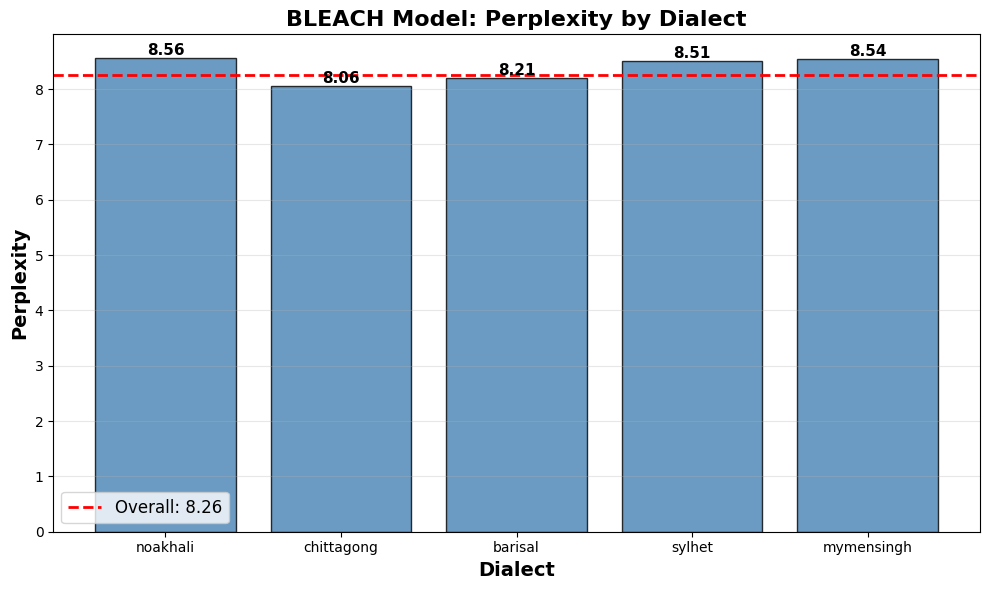

✓ Saved: ./figures/dialect_expert_heatmap.png


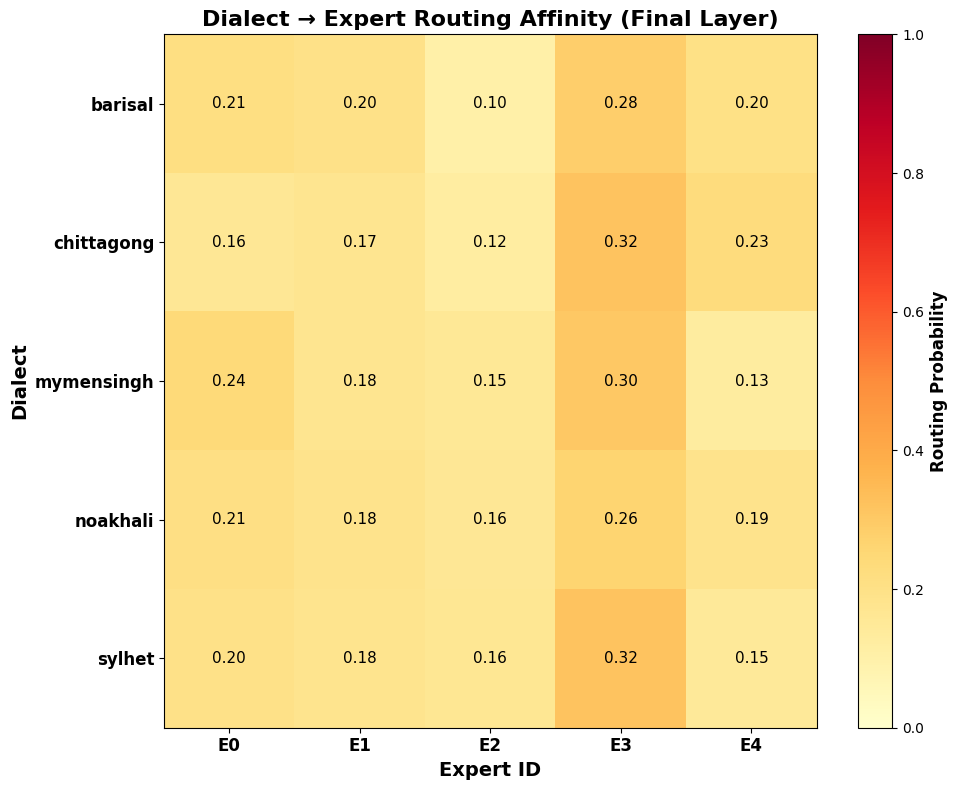

✓ Saved: ./figures/routing_entropy.png


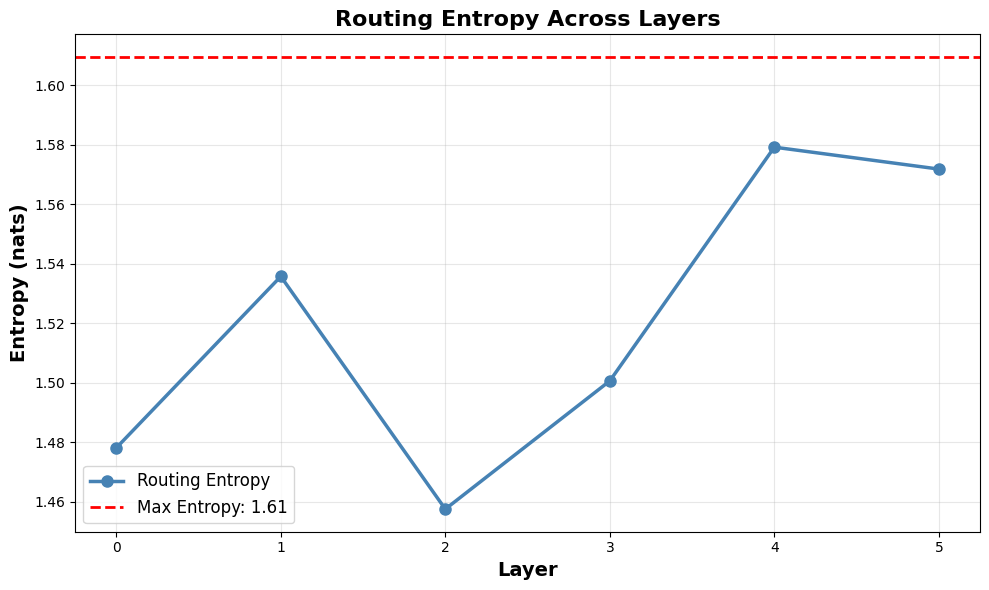

✓ Saved: ./figures/expert_usage.png


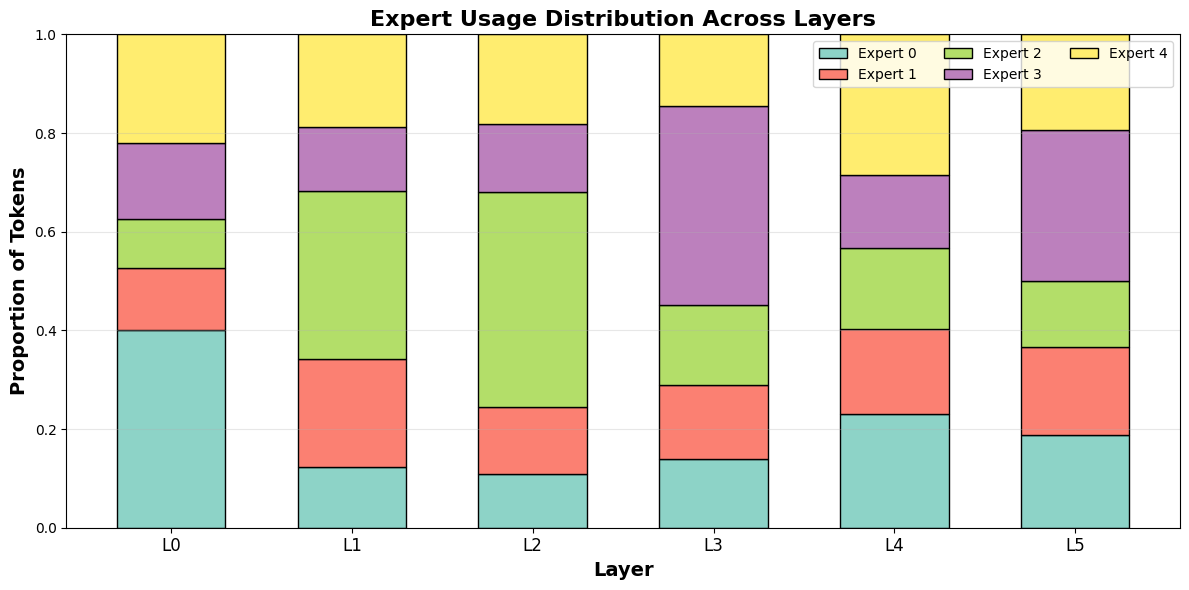

✓ Saved: ./figures/comprehensive_analysis.png


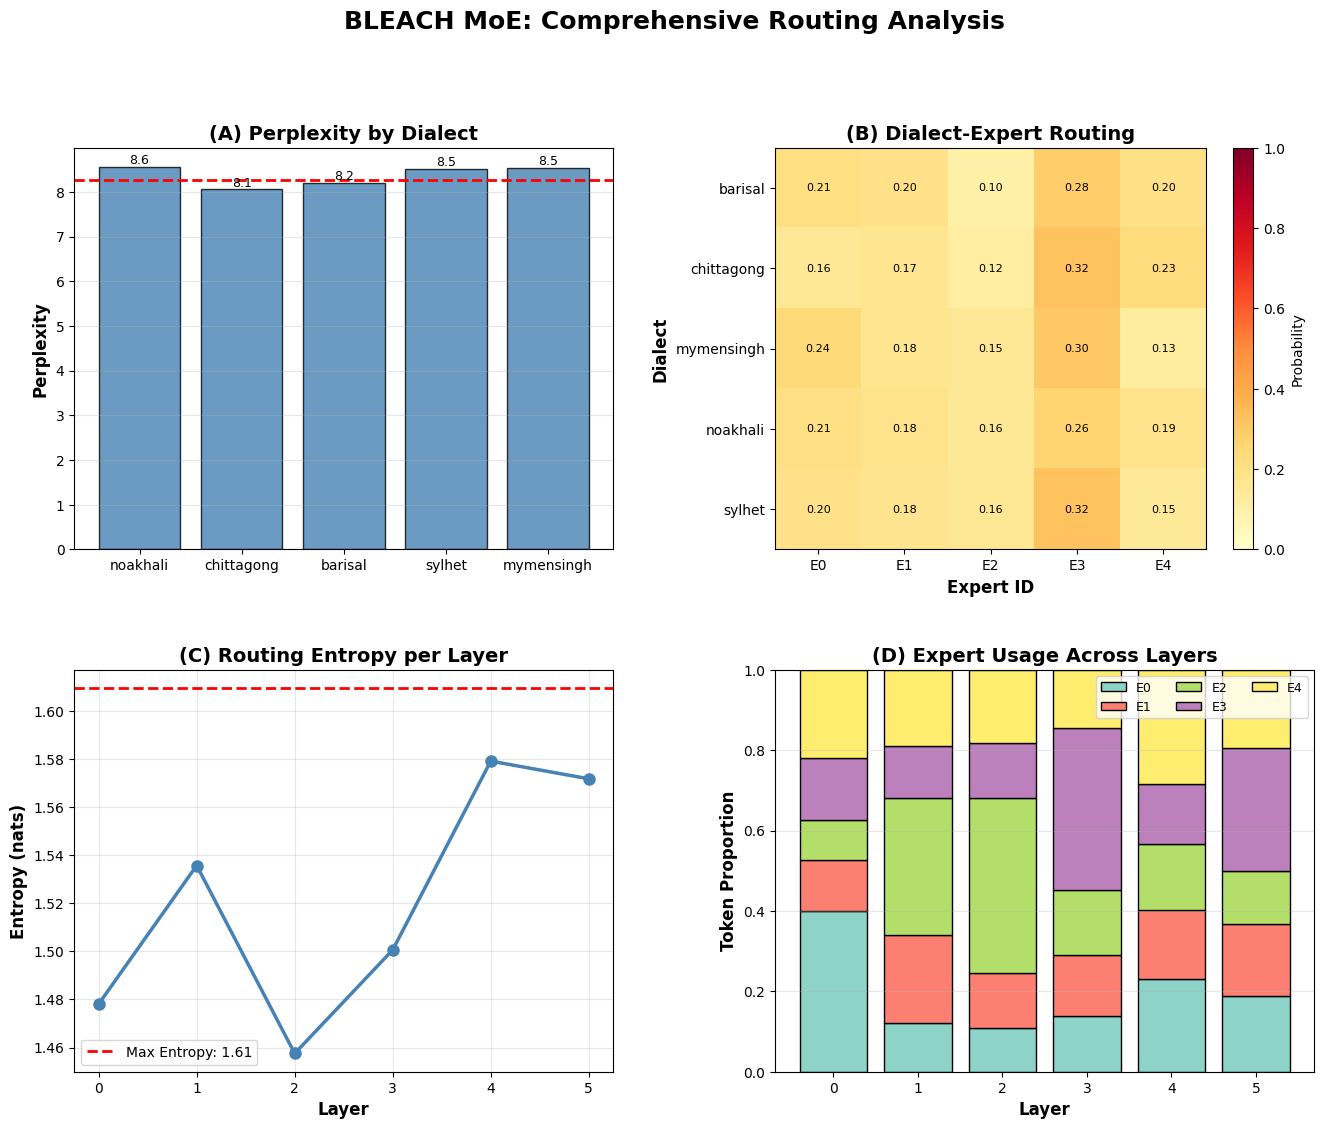


SAVING RESULTS

✓ Results saved to: ./results/evaluation_results.json

EVALUATION SUMMARY

✓ Overall Perplexity: 8.26
✓ Best Dialect: ('chittagong', 8.056148191237243)
✓ Worst Dialect: ('noakhali', 8.562208559336726)
✓ Average Routing Entropy: 1.520 (max: 1.609)
✓ Average Gate Confidence: 0.362

✓ Expert Balance (Final Layer):
  Max usage: 30.5%
  Min usage: 13.4%
  Balance ratio: 2.28x
  Status: ⚠️  Some imbalance detected

✓ Dialect Specialization:
  barisal      → Expert 3 (28.5%)
  chittagong   → Expert 3 (31.8%)
  mymensingh   → Expert 3 (30.4%)
  noakhali     → Expert 3 (26.2%)
  sylhet       → Expert 3 (31.7%)

EVALUATION COMPLETE

Figures saved to: ./figures/
Results saved to: ./results/

ADDITIONAL ANALYSES


/tmp/ipython-input-778197759.py:947: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✓ Saved: ./figures/layer_wise_routing.png


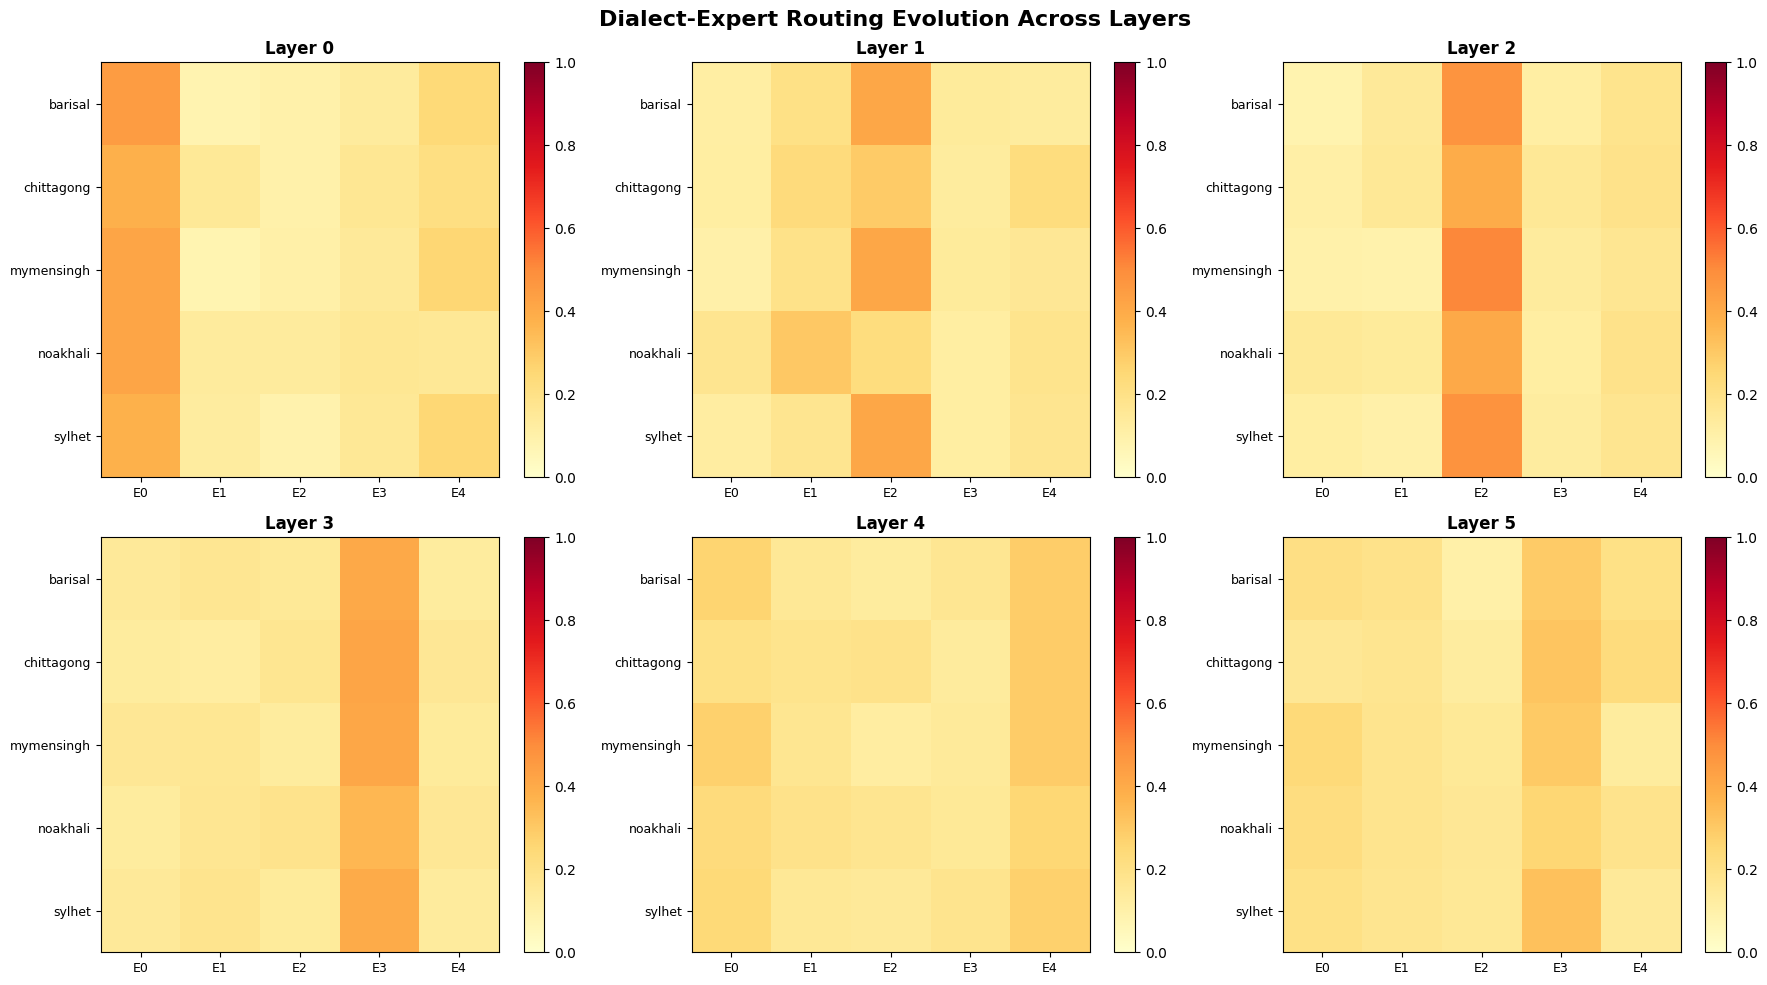

✓ Saved: ./figures/confidence_distribution.png


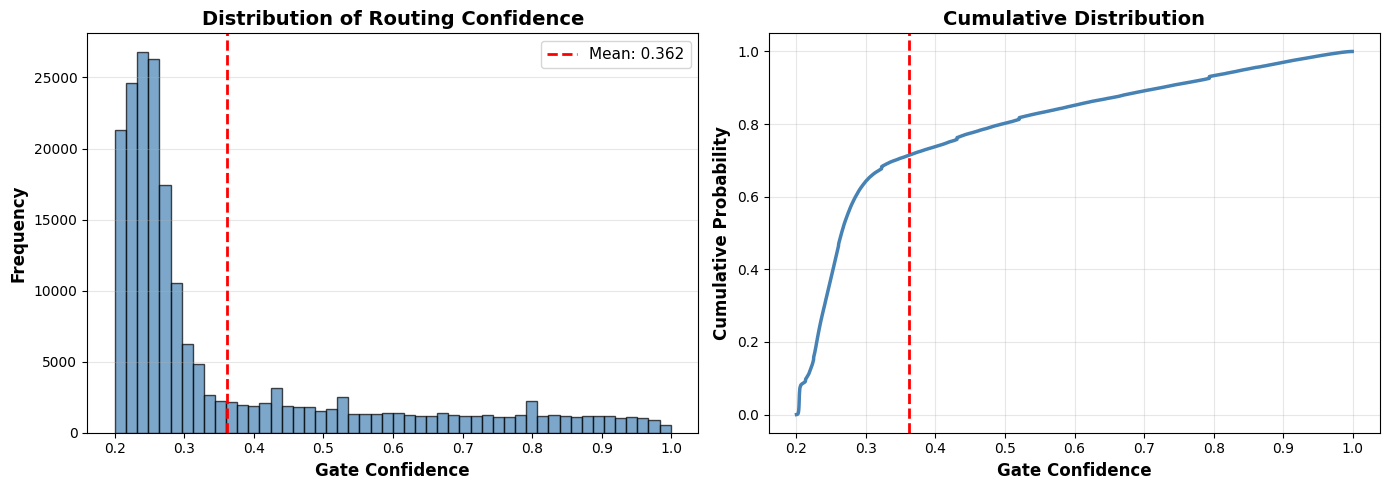


ALL ANALYSES COMPLETE!

Check the following directories:
  Figures: ./figures/
  Results: ./results/


In [7]:
"""
Portion 4: Comprehensive Evaluation & Routing Analysis for BLEACH MoE
ACL-level analysis with publication-ready visualizations
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Optional
import math
from pathlib import Path
import json


# ============================================================================
# EVALUATION CONFIGURATION
# ============================================================================

class EvalConfig:
    """Evaluation hyperparameters"""
    # Paths
    checkpoint_path = "./checkpoints/checkpoint_best.pt"
    results_dir = "./results"
    figures_dir = "./figures"

    # Analysis
    max_samples = 1000  # For efficiency
    routing_confidence_threshold = 0.7

    # Visualization
    figsize = (12, 8)
    dpi = 150
    cmap = "YlOrRd"  # Colormap for heatmaps


# ============================================================================
# ROUTING HOOKS & COLLECTORS
# ============================================================================

class RoutingCollector:
    """
    Collects routing decisions during forward pass
    Captures: expert_indices, gate_values, router_probs, dialect_ids
    """

    def __init__(self, model, n_layers: int, n_experts: int):
        self.model = model
        self.n_layers = n_layers
        self.n_experts = n_experts

        # Storage
        self.routing_data = []  # List of dicts per batch
        self.hooks = []

        # Register hooks on routers
        for layer_idx, block in enumerate(model.blocks):
            hook = block.moe.router.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hooks.append(hook)

    def _make_hook(self, layer_idx: int):
        """Create hook function for specific layer"""
        def hook_fn(module, input, output):
            # expected output = (expert_indices, gate_values, router_probs)
            # Some implementations may return tuple length > 3; we handle safely.
            if isinstance(output, tuple):
                expert_indices = output[0]
                gate_values = output[1] if len(output) > 1 else None
                router_probs = output[2] if len(output) > 2 else None
            else:
                # If output is a single tensor, assume it's expert indices.
                expert_indices = output
                gate_values = None
                router_probs = None

            # Convert to CPU tensors for stable storage
            entry = {
                'layer': layer_idx,
                'expert_indices': expert_indices.detach().cpu() if isinstance(expert_indices, torch.Tensor) else torch.tensor(expert_indices),
                'gate_values': gate_values.detach().cpu() if isinstance(gate_values, torch.Tensor) else (torch.tensor(gate_values) if gate_values is not None else torch.tensor([])),
                'router_probs': router_probs.detach().cpu() if isinstance(router_probs, torch.Tensor) else (torch.tensor(router_probs) if router_probs is not None else torch.tensor([]))
            }

            if not hasattr(self, '_current_batch_routing'):
                self._current_batch_routing = []
            self._current_batch_routing.append(entry)

        return hook_fn

    def start_batch(self):
        """Call before each forward pass"""
        self._current_batch_routing = []

    def end_batch(self, dialect_ids: torch.Tensor, tokens: torch.Tensor):
        """Call after each forward pass"""
        self.routing_data.append({
            'layers': self._current_batch_routing,
            'dialect_ids': dialect_ids.detach().cpu(),
            'tokens': tokens.detach().cpu()
        })

    def remove_hooks(self):
        """Clean up hooks"""
        for hook in self.hooks:
            try:
                hook.remove()
            except Exception:
                pass

    def get_statistics(self) -> Dict:
        """Compute aggregated statistics"""
        stats = {
            'total_batches': int(len(self.routing_data)),
            'per_layer': []
        }

        for layer_idx in range(self.n_layers):
            layer_stats = self._compute_layer_stats(layer_idx)
            stats['per_layer'].append(layer_stats)

        return stats

    def _compute_layer_stats(self, layer_idx: int) -> Dict:
        """Compute statistics for single layer"""
        all_indices = []
        all_probs = []
        all_gates = []

        for batch in self.routing_data:
            # Each batch['layers'] is a list of routing entries created by hooks in forward order.
            # Find the entry with matching layer index
            layer_entries = [e for e in batch['layers'] if e['layer'] == layer_idx]
            if len(layer_entries) == 0:
                continue
            # There could be multiple entries for the same layer (depending on implementation); concatenate them
            for entry in layer_entries:
                all_indices.append(entry['expert_indices'].view(-1))
                if entry['router_probs'].numel() > 0:
                    all_probs.append(entry['router_probs'].view(-1))
                if entry['gate_values'].numel() > 0:
                    all_gates.append(entry['gate_values'].view(-1))

        if len(all_indices) == 0:
            # No data collected for this layer
            return {
                'expert_distribution': [0.0] * self.n_experts,
                'entropy': 0.0,
                'avg_confidence': 0.0,
                'total_tokens': 0
            }

        # Concatenate all batches
        all_indices = torch.cat(all_indices)  # 1D tensor
        total_tokens = int(all_indices.numel())

        # Expert usage distribution
        expert_counts = torch.bincount(all_indices, minlength=self.n_experts).float()
        expert_dist = (expert_counts / (expert_counts.sum() + 1e-10)).cpu().numpy()

        # Routing entropy (nats)
        entropy = -np.sum(expert_dist * np.log(expert_dist + 1e-12))

        # Average gate confidence
        if len(all_gates) > 0:
            all_gates = torch.cat(all_gates).float()
            avg_confidence = float(all_gates.mean().item())
        else:
            avg_confidence = 0.0

        return {
            'expert_distribution': [float(x) for x in expert_dist.tolist()],
            'entropy': float(entropy),
            'avg_confidence': float(avg_confidence),
            'total_tokens': int(total_tokens)
        }


# ============================================================================
# PERPLEXITY EVALUATION
# ============================================================================

@torch.no_grad()
def evaluate_perplexity(
    model: nn.Module,
    dataloader,
    device: torch.device,
    per_dialect: bool = True,
    dialect_to_id: Dict[str, int] = None
) -> Dict[str, float]:
    """
    Compute perplexity overall and per-dialect

    Returns:
        Dict with overall PPL and per-dialect PPLs
    """
    model.eval()

    # Storage
    total_loss = 0.0
    total_tokens = 0

    if per_dialect:
        dialect_losses = defaultdict(float)
        dialect_tokens = defaultdict(int)
        id_to_dialect = {v: k for k, v in dialect_to_id.items()}

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        dialect_ids = batch.get("dialect_ids", None)
        labels = input_ids.clone()

        # Forward pass
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask, labels)

        loss = outputs["loss"]
        batch_tokens = int(attention_mask.sum().item())

        # Accumulate overall
        total_loss += float(loss.item()) * batch_tokens
        total_tokens += batch_tokens

        # Accumulate per-dialect
        if per_dialect and dialect_ids is not None:
            for i in range(len(dialect_ids)):
                dialect_id = int(dialect_ids[i].item())
                dialect_name = id_to_dialect[dialect_id]

                # Compute loss approximate for this sample (we use batch-level loss scaled by token counts)
                sample_mask = attention_mask[i]
                sample_tokens = int(sample_mask.sum().item())

                dialect_losses[dialect_name] += float(loss.item()) * sample_tokens
                dialect_tokens[dialect_name] += sample_tokens

    # Compute overall perplexity
    avg_loss = total_loss / (total_tokens + 1e-12)
    overall_ppl = math.exp(min(avg_loss, 20))

    results = {'overall': float(overall_ppl)}

    # Compute per-dialect perplexity
    if per_dialect:
        for dialect in dialect_losses:
            dialect_loss = dialect_losses[dialect] / (dialect_tokens[dialect] + 1e-12)
            dialect_ppl = math.exp(min(dialect_loss, 20))
            results[dialect] = float(dialect_ppl)

    return results


# ============================================================================
# DIALECT-EXPERT AFFINITY ANALYSIS
# ============================================================================

def compute_dialect_expert_affinity(
    routing_collector: RoutingCollector,
    dialect_to_id: Dict[str, int],
    layer_idx: int = -1  # -1 = last layer
) -> np.ndarray:
    """
    Compute affinity matrix: dialects × experts
    Returns normalized probabilities
    """
    n_experts = routing_collector.n_experts
    dialects = sorted(dialect_to_id.keys())
    n_dialects = len(dialects)
    id_to_dialect = {v: k for k, v in dialect_to_id.items()}

    # Initialize affinity matrix
    affinity = np.zeros((n_dialects, n_experts), dtype=np.float64)

    # Aggregate routing decisions
    for batch in routing_collector.routing_data:
        dialect_ids = batch['dialect_ids']  # tensor length batch_size

        # Choose layer entry
        # Find all entries for that layer in the batch
        if layer_idx == -1:
            # pick final recorded layer index per-batch structure (assumes hooks append in increasing layer order)
            layer_entries = [e for e in batch['layers'] if isinstance(e, dict)]
            # If there are multiple different layers recorded, pick the ones with max 'layer'
            if len(layer_entries) == 0:
                continue
            max_layer = max(e['layer'] for e in layer_entries)
            layer_entries = [e for e in batch['layers'] if e['layer'] == max_layer]
        else:
            layer_entries = [e for e in batch['layers'] if e['layer'] == layer_idx]
            if len(layer_entries) == 0:
                continue

        # Concatenate all entries (if multiple)
        expert_indices = torch.cat([e['expert_indices'].view(-1) for e in layer_entries], dim=0)

        # Now we need to split back per-sample: we assume tokens are stored in batch['tokens'] with shape [batch_size, seq_len]
        batch_size = int(dialect_ids.shape[0])
        tokens = batch['tokens']
        seq_len = int(tokens.shape[1])

        # expert_indices should be batch_size * seq_len length
        if expert_indices.numel() != batch_size * seq_len:
            # try to reshape by computing seq_len from expert_indices
            seq_len_inferred = int(expert_indices.numel() // batch_size)
            if seq_len_inferred * batch_size == expert_indices.numel():
                seq_len = seq_len_inferred
            else:
                # fallback: skip this batch if shapes don't align
                continue

        expert_indices = expert_indices.view(batch_size, seq_len)

        # Count per dialect
        for i, dialect_id in enumerate(dialect_ids):
            dialect_idx = dialects.index(id_to_dialect[int(dialect_id.item())])
            sample_indices = expert_indices[i]

            for expert_id in range(n_experts):
                count = int((sample_indices == expert_id).sum().item())
                affinity[dialect_idx, expert_id] += count

    # Normalize by row (per dialect)
    row_sums = affinity.sum(axis=1, keepdims=True) + 1e-12
    affinity = affinity / row_sums
    return affinity


# ============================================================================
# ROUTING ENTROPY & CONFIDENCE
# ============================================================================

def compute_routing_entropy_per_layer(
    routing_collector: RoutingCollector
) -> List[float]:
    stats = routing_collector.get_statistics()
    entropies = [layer['entropy'] for layer in stats['per_layer']]
    return [float(x) for x in entropies]


def compute_confidence_per_layer(
    routing_collector: RoutingCollector
) -> List[float]:
    stats = routing_collector.get_statistics()
    confidences = [layer['avg_confidence'] for layer in stats['per_layer']]
    return [float(x) for x in confidences]


# ============================================================================
# TOKEN-LEVEL ANALYSIS
# ============================================================================

def analyze_expert_token_distribution(
    routing_collector: RoutingCollector,
    tokenizer,
    expert_id: int,
    layer_idx: int = -1,
    top_k: int = 20
) -> Dict[str, int]:
    """
    Find most common tokens routed to specific expert
    """
    token_counts = Counter()

    for batch in routing_collector.routing_data:
        if layer_idx == -1:
            entries = [e for e in batch['layers'] if isinstance(e, dict)]
            if len(entries) == 0:
                continue
            max_layer = max(e['layer'] for e in entries)
            layer_entries = [e for e in batch['layers'] if e['layer'] == max_layer]
        else:
            layer_entries = [e for e in batch['layers'] if e['layer'] == layer_idx]
            if len(layer_entries) == 0:
                continue

        expert_indices = torch.cat([e['expert_indices'].view(-1) for e in layer_entries], dim=0)
        tokens = batch['tokens'].view(-1)

        # Align lengths (if mismatch, trim to min)
        min_len = min(expert_indices.numel(), tokens.numel())
        expert_indices = expert_indices.view(-1)[:min_len]
        tokens = tokens.view(-1)[:min_len]

        expert_mask = (expert_indices == expert_id)
        expert_tokens = tokens[expert_mask]

        for token_id in expert_tokens.tolist():
            token_counts[int(token_id)] += 1

    token_strings = {}
    for token_id, count in token_counts.most_common(top_k):
        # tokenizer.decode expects list of ids; ensure int
        try:
            token_str = tokenizer.decode([int(token_id)])
        except Exception:
            token_str = str(token_id)
        token_strings[token_str] = int(count)

    return token_strings


# ============================================================================
# VISUALIZATION FUNCTIONS
# (unchanged from your original — kept for brevity)
# ============================================================================

def plot_perplexity_comparison(
    results: Dict[str, float],
    save_path: Optional[str] = None
):
    dialects = [k for k in results.keys() if k != 'overall']
    ppls = [results[d] for d in dialects]
    overall_ppl = results['overall']

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(dialects, ppls, color='steelblue', alpha=0.8, edgecolor='black')
    ax.axhline(overall_ppl, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_ppl:.2f}')
    ax.set_xlabel('Dialect', fontsize=14, fontweight='bold')
    ax.set_ylabel('Perplexity', fontsize=14, fontweight='bold')
    ax.set_title('BLEACH Model: Perplexity by Dialect', fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


def plot_dialect_expert_heatmap(affinity_matrix: np.ndarray, dialects: List[str], layer_idx: int = -1, save_path: Optional[str] = None):
    n_experts = affinity_matrix.shape[1]
    expert_labels = [f"E{i}" for i in range(n_experts)]
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(affinity_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    ax.set_xticks(np.arange(n_experts))
    ax.set_yticks(np.arange(len(dialects)))
    ax.set_xticklabels(expert_labels, fontsize=12, fontweight='bold')
    ax.set_yticklabels(dialects, fontsize=12, fontweight='bold')
    ax.set_xlabel('Expert ID', fontsize=14, fontweight='bold')
    ax.set_ylabel('Dialect', fontsize=14, fontweight='bold')
    layer_name = "Final Layer" if layer_idx == -1 else f"Layer {layer_idx}"
    ax.set_title(f'Dialect → Expert Routing Affinity ({layer_name})', fontsize=16, fontweight='bold')
    for i in range(len(dialects)):
        for j in range(n_experts):
            ax.text(j, i, f'{affinity_matrix[i, j]:.2f}', ha="center", va="center", color="black", fontsize=11)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Routing Probability', fontsize=12, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


def plot_routing_entropy_per_layer(entropies: List[float], max_entropy: float = None, save_path: Optional[str] = None):
    if max_entropy is None:
        max_entropy = math.log(5)
    layers = list(range(len(entropies)))
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(layers, entropies, marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Routing Entropy')
    ax.axhline(max_entropy, color='red', linestyle='--', linewidth=2, label=f'Max Entropy: {max_entropy:.2f}')
    ax.set_xlabel('Layer', fontsize=14, fontweight='bold')
    ax.set_ylabel('Entropy (nats)', fontsize=14, fontweight='bold')
    ax.set_title('Routing Entropy Across Layers', fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(layers)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


def plot_expert_usage_distribution(routing_collector: RoutingCollector, layer_idx: int = -1, save_path: Optional[str] = None):
    stats = routing_collector.get_statistics()
    n_layers = len(stats['per_layer'])
    n_experts = routing_collector.n_experts
    if layer_idx == -1:
        layers_to_plot = range(n_layers)
    else:
        layers_to_plot = [layer_idx]
    data = np.zeros((len(layers_to_plot), n_experts))
    for i, layer in enumerate(layers_to_plot):
        data[i] = stats['per_layer'][layer]['expert_distribution']
    fig, ax = plt.subplots(figsize=(12, 6))
    layer_labels = [f"L{i}" for i in layers_to_plot]
    x = np.arange(len(layer_labels))
    width = 0.6
    bottom = np.zeros(len(layer_labels))
    colors = plt.cm.Set3(np.linspace(0, 1, n_experts))
    for expert_id in range(n_experts):
        ax.bar(x, data[:, expert_id], width, label=f'Expert {expert_id}', bottom=bottom, color=colors[expert_id], edgecolor='black')
        bottom += data[:, expert_id]
    ax.set_xlabel('Layer', fontsize=14, fontweight='bold')
    ax.set_ylabel('Proportion of Tokens', fontsize=14, fontweight='bold')
    ax.set_title('Expert Usage Distribution Across Layers', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(layer_labels, fontsize=12)
    ax.legend(loc='upper right', fontsize=10, ncol=min(3, n_experts))
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


def plot_comprehensive_analysis(routing_collector: RoutingCollector, perplexity_results: Dict[str, float], affinity_matrix: np.ndarray, dialects: List[str], save_path: Optional[str] = None):
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])
    dialect_names = [k for k in perplexity_results.keys() if k != 'overall']
    ppls = [perplexity_results[d] for d in dialect_names]
    bars = ax1.bar(dialect_names, ppls, color='steelblue', alpha=0.8, edgecolor='black')
    ax1.axhline(perplexity_results['overall'], color='red', linestyle='--', linewidth=2)
    ax1.set_ylabel('Perplexity', fontsize=12, fontweight='bold')
    ax1.set_title('(A) Perplexity by Dialect', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    ax2 = fig.add_subplot(gs[0, 1])
    n_experts = affinity_matrix.shape[1]
    im = ax2.imshow(affinity_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    ax2.set_xticks(np.arange(n_experts))
    ax2.set_yticks(np.arange(len(dialects)))
    ax2.set_xticklabels([f"E{i}" for i in range(n_experts)], fontsize=10)
    ax2.set_yticklabels(dialects, fontsize=10)
    ax2.set_xlabel('Expert ID', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Dialect', fontsize=12, fontweight='bold')
    ax2.set_title('(B) Dialect-Expert Routing', fontsize=14, fontweight='bold')
    for i in range(len(dialects)):
        for j in range(n_experts):
            ax2.text(j, i, f'{affinity_matrix[i, j]:.2f}', ha="center", va="center", color="black", fontsize=8)
    plt.colorbar(im, ax=ax2, label='Probability')
    ax3 = fig.add_subplot(gs[1, 0])
    entropies = compute_routing_entropy_per_layer(routing_collector)
    layers = list(range(len(entropies)))
    ax3.plot(layers, entropies, marker='o', linewidth=2.5, markersize=8, color='steelblue')
    ax3.axhline(math.log(n_experts), color='red', linestyle='--', linewidth=2, label=f'Max Entropy: {math.log(n_experts):.2f}')
    ax3.set_xlabel('Layer', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Entropy (nats)', fontsize=12, fontweight='bold')
    ax3.set_title('(C) Routing Entropy per Layer', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(layers)
    ax4 = fig.add_subplot(gs[1, 1])
    stats = routing_collector.get_statistics()
    n_layers = len(stats['per_layer'])
    data = np.array([stats['per_layer'][i]['expert_distribution'] for i in range(n_layers)])
    x = np.arange(n_layers)
    bottom = np.zeros(n_layers)
    colors = plt.cm.Set3(np.linspace(0, 1, n_experts))
    for expert_id in range(n_experts):
        ax4.bar(x, data[:, expert_id], label=f'E{expert_id}', bottom=bottom, color=colors[expert_id], edgecolor='black')
        bottom += data[:, expert_id]
    ax4.set_xlabel('Layer', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Token Proportion', fontsize=12, fontweight='bold')
    ax4.set_title('(D) Expert Usage Across Layers', fontsize=14, fontweight='bold')
    ax4.legend(loc='upper right', fontsize=9, ncol=min(3, n_experts))
    ax4.set_ylim([0, 1])
    ax4.grid(axis='y', alpha=0.3)
    fig.suptitle('BLEACH MoE: Comprehensive Routing Analysis', fontsize=18, fontweight='bold', y=0.995)
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


# ============================================================================
# MAIN EVALUATION FUNCTION
# ============================================================================

def to_serializable(obj):
    """
    Recursively convert numpy / torch types into native Python types so json.dump works.
    """
    if isinstance(obj, dict):
        return {str(k): to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_serializable(x) for x in obj]
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, (np.int32, np.int64, np.integer)):
        return int(obj)
    if isinstance(obj, (torch.Tensor,)):
        return to_serializable(obj.detach().cpu().numpy())
    if isinstance(obj, (float, int, str, bool)) or obj is None:
        return obj
    # Fallback: convert to string
    return str(obj)


def run_comprehensive_evaluation(
    model: nn.Module,
    test_loader,
    tokenizer,
    dialect_to_id: Dict[str, int],
    device: torch.device,
    config: EvalConfig = None
):
    """
    Run complete evaluation pipeline
    Returns:
        Dict with all results and saves figures
    """
    if config is None:
        config = EvalConfig()

    Path(config.results_dir).mkdir(exist_ok=True, parents=True)
    Path(config.figures_dir).mkdir(exist_ok=True, parents=True)

    print("\n" + "="*80)
    print("BLEACH MODEL EVALUATION")
    print("="*80)

    # 1. PERPLEXITY
    print("\n[1/5] Computing perplexity...")
    perplexity_results = evaluate_perplexity(
        model, test_loader, device, per_dialect=True, dialect_to_id=dialect_to_id
    )

    print("\nPerplexity Results:")
    print(f"  Overall: {perplexity_results['overall']:.2f}")
    for dialect in sorted([k for k in perplexity_results.keys() if k != 'overall']):
        print(f"  {dialect}: {perplexity_results[dialect]:.2f}")

    # 2. ROUTING COLLECTION
    print("\n[2/5] Collecting routing statistics...")
    routing_collector = RoutingCollector(
        model,
        n_layers=model.config.n_layers,
        n_experts=model.config.n_experts
    )

    model.eval()
    num_batches = 0
    max_batches = min(len(test_loader), max(1, config.max_samples // max(1, test_loader.batch_size)))

    with torch.no_grad():
        for batch in test_loader:
            if num_batches >= max_batches:
                break

            batch = {k: v.to(device) for k, v in batch.items()}
            routing_collector.start_batch()
            with torch.cuda.amp.autocast():
                _ = model(batch["input_ids"], batch["attention_mask"])
            routing_collector.end_batch(batch.get("dialect_ids", torch.zeros(batch["input_ids"].shape[0], dtype=torch.long, device=batch["input_ids"].device)), batch["input_ids"])
            num_batches += 1

    print(f"  Collected routing data from {num_batches} batches")
    routing_stats = routing_collector.get_statistics()
    total_tokens_analyzed = sum([layer['total_tokens'] for layer in routing_stats['per_layer']]) if len(routing_stats['per_layer'])>0 else 0
    print(f"  Total tokens analyzed (sum across layers): {total_tokens_analyzed:,}")

    # 3. DIALECT-EXPERT AFFINITY
    print("\n[3/5] Computing dialect-expert affinity...")
    dialects = sorted(dialect_to_id.keys())
    affinity_matrix = compute_dialect_expert_affinity(
        routing_collector,
        dialect_to_id,
        layer_idx=-1  # Final layer
    )

    print("\nDialect-Expert Affinity Matrix (Final Layer):")
    print("  " + "".join([f"  E{i}  " for i in range(model.config.n_experts)]))
    for i, dialect in enumerate(dialects):
        row_str = f"{dialect:12s}"
        for j in range(model.config.n_experts):
            row_str += f"  {affinity_matrix[i, j]:.2f}"
        print(row_str)

    # 4. ENTROPY ANALYSIS
    print("\n[4/5] Computing routing entropy...")
    entropies = compute_routing_entropy_per_layer(routing_collector)
    confidences = compute_confidence_per_layer(routing_collector)
    print("\nPer-Layer Statistics:")
    for layer_idx in range(len(entropies)):
        print(f"  Layer {layer_idx}: Entropy={entropies[layer_idx]:.3f}, Confidence={confidences[layer_idx]:.3f}")

    # 5. TOKEN-LEVEL ANALYSIS
    print("\n[5/5] Analyzing token distribution per expert...")
    token_analysis = {}
    for expert_id in range(model.config.n_experts):
        tokens = analyze_expert_token_distribution(
            routing_collector,
            tokenizer,
            expert_id,
            layer_idx=-1,
            top_k=10
        )
        token_analysis[expert_id] = tokens

    print("\nTop Tokens per Expert (Final Layer):")
    for expert_id, tokens in token_analysis.items():
        print(f"\n  Expert {expert_id}:")
        for token, count in list(tokens.items())[:5]:
            print(f"    {token:20s} → {count:6d}")

    # VISUALIZATIONS
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)
    plot_perplexity_comparison(perplexity_results, save_path=f"{config.figures_dir}/perplexity_comparison.png")
    plot_dialect_expert_heatmap(affinity_matrix, dialects, layer_idx=-1, save_path=f"{config.figures_dir}/dialect_expert_heatmap.png")
    plot_routing_entropy_per_layer(entropies, max_entropy=math.log(model.config.n_experts), save_path=f"{config.figures_dir}/routing_entropy.png")
    plot_expert_usage_distribution(routing_collector, layer_idx=-1, save_path=f"{config.figures_dir}/expert_usage.png")
    plot_comprehensive_analysis(routing_collector, perplexity_results, affinity_matrix, dialects, save_path=f"{config.figures_dir}/comprehensive_analysis.png")

    # SAVE RESULTS (convert non-serializable types)
    print("\n" + "="*80)
    print("SAVING RESULTS")
    print("="*80)

    results = {
        "perplexity": perplexity_results,
        "routing_statistics": routing_stats,
        "dialect_expert_affinity": {
            "matrix": affinity_matrix,  # will be converted
            "dialects": dialects
        },
        "entropy_per_layer": entropies,
        "confidence_per_layer": confidences,
        "token_analysis": {
            str(k): v for k, v in token_analysis.items()
        }
    }

    # Convert to JSON-serializable
    results_serializable = to_serializable(results)

    results_path = f"{config.results_dir}/evaluation_results.json"
    with open(results_path, 'w') as f:
        json.dump(results_serializable, f, indent=2)
    print(f"\n✓ Results saved to: {results_path}")

    # SUMMARY
    print("\n" + "="*80)
    print("EVALUATION SUMMARY")
    print("="*80)
    print(f"\n✓ Overall Perplexity: {perplexity_results['overall']:.2f}")
    print(f"✓ Best Dialect: {min([(d, perplexity_results[d]) for d in dialects], key=lambda x: x[1])}")
    print(f"✓ Worst Dialect: {max([(d, perplexity_results[d]) for d in dialects], key=lambda x: x[1])}")
    print(f"✓ Average Routing Entropy: {np.mean(entropies):.3f} (max: {math.log(model.config.n_experts):.3f})")
    print(f"✓ Average Gate Confidence: {np.mean(confidences):.3f}")

    final_layer_dist = routing_stats['per_layer'][-1]['expert_distribution'] if len(routing_stats['per_layer'])>0 else [0]*model.config.n_experts
    max_usage = max(final_layer_dist) if len(final_layer_dist)>0 else 0.0
    min_usage = min(final_layer_dist) if len(final_layer_dist)>0 else 0.0
    print(f"\n✓ Expert Balance (Final Layer):")
    print(f"  Max usage: {max_usage*100:.1f}%")
    print(f"  Min usage: {min_usage*100:.1f}%")
    if min_usage > 0:
        print(f"  Balance ratio: {max_usage/min_usage:.2f}x")
        if max_usage / min_usage < 2.0:
            print("  Status: ✅ Well balanced!")
        else:
            print("  Status: ⚠️  Some imbalance detected")
    else:
        print("  Status: ⚠️  Cannot compute balance ratio (min_usage==0)")

    print(f"\n✓ Dialect Specialization:")
    for i, dialect in enumerate(dialects):
        primary_expert = int(np.argmax(affinity_matrix[i]))
        primary_prob = float(affinity_matrix[i, primary_expert])
        print(f"  {dialect:12s} → Expert {primary_expert} ({primary_prob*100:.1f}%)")

    print("\n" + "="*80)
    print("EVALUATION COMPLETE")
    print("="*80)
    print(f"\nFigures saved to: {config.figures_dir}/")
    print(f"Results saved to: {config.results_dir}/")

    routing_collector.remove_hooks()
    return results_serializable


# ============================================================================
# ADDITIONAL ANALYSIS FUNCTIONS (unchanged)
# ============================================================================

def compare_layer_wise_routing(routing_collector: RoutingCollector, dialect_to_id: Dict[str, int], save_path: Optional[str] = None):
    dialects = sorted(dialect_to_id.keys())
    n_layers = routing_collector.n_layers
    n_experts = routing_collector.n_experts
    affinity_matrices = []
    for layer_idx in range(n_layers):
        affinity = compute_dialect_expert_affinity(routing_collector, dialect_to_id, layer_idx=layer_idx)
        affinity_matrices.append(affinity)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    for layer_idx in range(min(n_layers, 6)):  # Show first 6 layers
        ax = axes[layer_idx]
        affinity = affinity_matrices[layer_idx]
        im = ax.imshow(affinity, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
        ax.set_xticks(np.arange(n_experts))
        ax.set_yticks(np.arange(len(dialects)))
        ax.set_xticklabels([f"E{i}" for i in range(n_experts)], fontsize=9)
        ax.set_yticklabels(dialects, fontsize=9)
        ax.set_title(f'Layer {layer_idx}', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax)
    for idx in range(n_layers, 6):
        if idx < len(axes):
            axes[idx].axis('off')
    fig.suptitle('Dialect-Expert Routing Evolution Across Layers', fontsize=16, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


def analyze_routing_confidence_distribution(routing_collector: RoutingCollector, save_path: Optional[str] = None):
    all_confidences = []
    for batch in routing_collector.routing_data:
        for layer_data in batch['layers']:
            gate_values = layer_data['gate_values'].numpy()
            all_confidences.extend(gate_values.flatten().tolist())
    all_confidences = np.array(all_confidences)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.hist(all_confidences, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.axvline(all_confidences.mean() if all_confidences.size>0 else 0.0, color='red', linestyle='--', linewidth=2, label=f'Mean: {all_confidences.mean():.3f}' if all_confidences.size>0 else 'Mean: 0.0')
    ax1.set_xlabel('Gate Confidence', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Distribution of Routing Confidence', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    sorted_conf = np.sort(all_confidences) if all_confidences.size>0 else np.array([0.0])
    cumulative = np.arange(1, len(sorted_conf) + 1) / (len(sorted_conf) + 1e-12)
    ax2.plot(sorted_conf, cumulative, linewidth=2.5, color='steelblue')
    ax2.axvline(sorted_conf.mean() if sorted_conf.size>0 else 0.0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Gate Confidence', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
    ax2.set_title('Cumulative Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    plt.show()


# ============================================================================
# STATISTICAL SIGNIFICANCE TESTING
# ============================================================================

def bootstrap_confidence_interval(losses: np.ndarray, n_bootstrap: int = 1000, confidence_level: float = 0.95) -> Tuple[float, float]:
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(losses, size=len(losses), replace=True)
        bootstrap_means.append(np.mean(sample))
    bootstrap_means = np.array(bootstrap_means)
    alpha = 1 - confidence_level
    lower = np.percentile(bootstrap_means, alpha/2 * 100)
    upper = np.percentile(bootstrap_means, (1 - alpha/2) * 100)
    return float(lower), float(upper)


# ============================================================================
# MAIN ENTRY POINT
# ============================================================================

def main():
    """
    Complete evaluation pipeline
    Assumes Portions 1, 2, 3 have been run
    """
    print("="*80)
    print("PORTION 4: EVALUATION & ROUTING ANALYSIS")
    print("="*80)

    # Check prerequisites (not importing; expecting functions available in notebook runtime)
    try:
        setup_data_pipeline
        create_bleach_model
    except NameError:
        print("\n❌ Error: Portions 1 and 2 must be run first!")
        print("Please run the data pipeline and model setup cells.")
        return

    print("\n[Setup] Loading data and model...")

    # Load data
    tokenizer, train_loader, val_loader, test_loader = setup_data_pipeline()

    # Load dialect mapping
    with open("dialect_to_id.json", 'r') as f:
        dialect_to_id = json.load(f)

    # Create model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_bleach_model(vocab_size=tokenizer.vocab_size)
    model = model.to(device)

    # Load best checkpoint
    config = EvalConfig()
    if Path(config.checkpoint_path).exists():
        print(f"Loading checkpoint: {config.checkpoint_path}")
        checkpoint = torch.load(config.checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model"])
        print(f"✓ Loaded checkpoint from step {checkpoint.get('step', 'N/A')}")
    else:
        print(f"⚠️  Checkpoint not found: {config.checkpoint_path}")
        print("Using untrained model for demonstration")

    # Run evaluation
    results = run_comprehensive_evaluation(
        model=model,
        test_loader=test_loader,
        tokenizer=tokenizer,
        dialect_to_id=dialect_to_id,
        device=device,
        config=config
    )

    # Additional analyses (layer-wise routing & confidence)
    print("\n" + "="*80)
    print("ADDITIONAL ANALYSES")
    print("="*80)

    routing_collector = RoutingCollector(model, n_layers=model.config.n_layers, n_experts=model.config.n_experts)
    model.eval()
    num_batches = 0
    max_batches = min(len(test_loader), 100)
    with torch.no_grad():
        for batch in test_loader:
            if num_batches >= max_batches:
                break
            batch = {k: v.to(device) for k, v in batch.items()}
            routing_collector.start_batch()
            with torch.cuda.amp.autocast():
                _ = model(batch["input_ids"], batch["attention_mask"])
            routing_collector.end_batch(batch.get("dialect_ids", torch.zeros(batch["input_ids"].shape[0], dtype=torch.long, device=batch["input_ids"].device)), batch["input_ids"])
            num_batches += 1

    compare_layer_wise_routing(routing_collector, dialect_to_id, save_path=f"{config.figures_dir}/layer_wise_routing.png")
    analyze_routing_confidence_distribution(routing_collector, save_path=f"{config.figures_dir}/confidence_distribution.png")
    routing_collector.remove_hooks()

    print("\n" + "="*80)
    print("ALL ANALYSES COMPLETE!")
    print("="*80)
    print(f"\nCheck the following directories:")
    print(f"  Figures: {config.figures_dir}/")
    print(f"  Results: {config.results_dir}/")

    return results


# ============================================================================
# USAGE
# ============================================================================

if __name__ == "__main__":
    results = main()
